This notebook reproduces part of the figures related to the lung-analysis of the Muus et al. 2020 publication (Fig. 2a,c, Ext. Data Fig. 3, Suppl. Fig. 15). The only additional file that is needed to run this notebook is the cell by gene matrix with matching annotations, as stored in the .h5ad object that is supplementary data D3 in the paper. 

In [1]:
import scanpy as sc
import numpy as np
# import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import logging, warnings
# from matplotlib import rc
import matplotlib.ticker as pltticker

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.rcParams["figure.figsize"] = (8, 8)  # rescale figures
plt.rcParams.update({"figure.autolayout": True})
sc.settings.verbosity = 3
sc.logging.print_versions()

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 105)

scanpy==1.4.5.post2.dev10+gfe8a584 anndata==0.7.4 umap==0.3.10 numpy==1.17.4 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.21.3 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


In [3]:
# User inputs
# where to store figures:
folder = "/home/muus_et_al/figures/"
# path to adata.h5ad file
adata_path = "/home/muus_et_al/Supplementary_Data_D3.h5ad"

# Read the data

import data:

In [4]:
adata = sc.read(adata_path)

inspect AnnData object:

In [5]:
adata

AnnData object with n_obs × n_vars = 1320896 × 3
    obs: 'age', 'donor', 'last_author/PI', 'lung_vs_nasal', 'original_celltype_ann', 'sample', 'sex', 'smoking', 'total_counts', 'smoked_boolean', 'last_author_sample_name', 'ann_level_1', 'ann_level_2', 'ann_level_3'

print number of samples:

In [6]:
adata.obs["last_author_sample_name"].nunique()

377

print number of datasets:

In [7]:
adata.obs["last_author/PI"].nunique()

31

make sure age is float type

In [8]:
adata.obs.age = adata.obs.age.astype(float)

list number of adult and fetal cells, split into lung versus nasal:

In [9]:
adata.obs["adult_vs_fetal"] = [
    "adult" if age >= 0 else "fetal" for age in adata.obs.age
]

In [10]:
adata.obs.groupby(["lung_vs_nasal", "adult_vs_fetal"]).agg(
    {"lung_vs_nasal": "count", "donor": "nunique", "sample": "nunique"}
).rename(
    columns={"lung_vs_nasal": "n_cells", "donor": "n_donors", "sample": "n_samples"}
)

n_cells  n_donors  n_samples
lung_vs_nasal adult_vs_fetal                              
lung          adult           1126898       187        316
              fetal            136450        34         41
nasal         adult             57548        18         20
              fetal                 0         0          0

## Choose age group, annotation level, and genes for double-positive status:

Choose whether to include all samples, or only those from young donors/patients. Set to either 'all' or 'young':

In [11]:
ages = "all"  # set to either "young" or "all". "young" was only used for Ext. Data Fig. 3b,c

In [12]:
if ages not in ["young", "all"]:
    print('ages variable should be set to either "young" or "all"!')
else:
    print("Using samples from {} donors/patients".format(ages))

Using samples from all donors/patients


Choose which level of annotation to look at (1: coarsest, 3: finest)

In [13]:
level = 3  # choose 1, 2 or 3
level_name = "ann_level_" + str(level)

specify genes for which we want to study 'double positiveness'

In [14]:
genes = ["ACE2", "TMPRSS2"]

## Create relevant AnnData objects, and annotate with double-positive status:

annotate cells with Boolean specifying whether cell is double positive or not

In [15]:
adata.obs["doub_pos"] = (adata[:, genes[0]].X > 0).A & (adata[:, genes[1]].X > 0).A

store those celltypes that have at least one double positive cell, under "cell_types" variable. Similarly, store celltypes that have more than 10 dp cells under cell_types_10. In case the ann level is ann_level_3, don't include 1_ forward propagated level_1 labels in cell_types_10 either.

In [16]:
ct_dp_sum = adata.obs.groupby(level_name).agg({"doub_pos": "sum"})
cell_types = [
    ct
    for ct in ct_dp_sum.index[ct_dp_sum["doub_pos"] > 0]
    if ct != "Unicorns and artifacts"
]
cell_types_10 = [
    ct
    for ct in ct_dp_sum.index[ct_dp_sum["doub_pos"] > 10]
    if ct != "Unicorns and artifacts"
]
if level_name == "ann_level_3":
    cell_types_10 = [ct for ct in cell_types_10 if not ct.startswith("1_")]

add age group annotation:

In [17]:
adata.obs["age_bins"] = [
    "First TM"
    if (age <= -0.54)
    else "Second TM"
    if (age > -0.54 and age < 0)
    else "Pediatric"
    if (age >= 0 and age <= 10)
    else "Age 10-25"
    if (age > 10 and age <= 25)
    else "Age 25-40"
    if (age > 25 and age <= 40)
    else "Age 40-60"
    if (age > 40 and age <= 60)
    else "Age 60+"
    for age in adata.obs.age
]
# make sure categories are ordered by age
adata.obs["age_bins"] = (
    adata.obs["age_bins"]
    .astype("category")
    .cat.set_categories(
        [
            "First TM",
            "Second TM",
            "Pediatric",
            "Age 10-25",
            "Age 25-40",
            "Age 40-60",
            "Age 60+",
        ],
        ordered=True,
    )
)
# age strings:
adata.obs["age_string"] = [
    "3 months"
    if age == 0.25
    else str(age).split(".")[0] + " years"
    if age > 0
    else adata.obs["sample"][i][:2] + " weeks"
    if (age == 0)
    else "First TM"
    if (age < -0.54)
    else "Second TM"
    for i, age in enumerate(adata.obs.age)
]

store anndata object of all cells except "Unicorns and artifacts" (low quality cells). If chosen age group is 'young', only select samples from donors with age 10 and younger, and add age group annotation.

In [18]:
if ages == "all":
    adata_full = adata[(adata.obs["ann_level_1"] != "Unicorns and artifacts"), :].copy()
elif ages == "young":
    # take only samples with donor/patient age 10 or younger
    adata_full = adata[
        (adata.obs["ann_level_1"] != "Unicorns and artifacts")
        & (adata.obs["age"] <= 10),
        :,
    ].copy()
else:
    print('ages variable should be set to either "all" or "young"!')

rename 'SC' level 3 clusternames, since they only belong to a single sample each and are therefore not useful for this aggregate analysis (they all come from the Misharin dataset)

In [19]:
# get set of labels at ann_level_3
lev_3_celltypes_all = sorted(set(adata_full.obs["ann_level_3"]))
# create a renamer dictionary, initially with identical keys and values:
celltype_renamer = dict(zip(lev_3_celltypes_all, lev_3_celltypes_all))
# now rename the SC labels:
# smooth muscle to level 2 smooth muscle:
for ct in [
    "SC86_C7_SM_1",
    "SC86_C17_SM_2",
    "SC85_C15_SMC",
    "SC86_C18_SM_3",
    "SC89_C8_SM",
    "SC88_C22_SMC",
]:
    celltype_renamer[ct] = "2_Smooth Muscle"
# Mesothelial_2_DEFB4A' to level 2 mesothelium:
celltype_renamer["SC89_C11_Mesothelial_2_DEFB4A"] = "2_Mesothelium"
# now rename ann_level_3
adata_full.obs["ann_level_3"] = adata_full.obs["ann_level_3"].map(celltype_renamer)

create a 'simplified annotation' column in adata_full.obs, that contains 1) cell type names of cell_types from the level under consideration that have at least 10 double positive cells in the entire dataset (i.e. in cell_types_10 as defined above)
2) 'Other' for all others 

In [20]:
cells_other = [
    cell
    for cell, ct in zip(adata_full.obs.index, adata_full.obs[level_name])
    if (ct not in cell_types_10)  # cell types that have no double positives
]
# store simplified version of annotation in a separate .obs column
adata_full.obs["simpl_annotation"] = adata_full.obs[level_name].tolist()
# now set cells_other to "Other"
adata_full.obs.loc[cells_other, "simpl_annotation"] = "Other"

add annotation containing normalized expression for the genes in our AnnData object ("[gene]_norm"), and an annotation specifying if the cell had at least one count for the gene ("[gene]_positive")

In [21]:
for gene in adata_full.var.index:
    adata_full.obs[gene + "_norm"] = (
        adata_full[:, gene].X.toarray()
        / adata_full.obs.total_counts.values[:, None]
        * 10 ** 4
    )
for gene in adata_full.var.index:
    adata_full.obs[gene + "_positive"] = adata_full[:, gene].X.toarray() > 0

store AnnData object with only double positive cells in a separate object

In [22]:
adata_dp_full = adata_full[adata_full.obs["doub_pos"], :].copy()

## Cluster samples and plot sample ann level 2 compositions, ordering samples by cluster (Fig. 2a):

Here we will cluster the samples based on their cell type composition. We will use level 2 cell type annotations for that. Level 1 has only 5 categories and would take too little information into account, and level 3 is too fine: many cells don't have level 3 cell type annotations.

### Plot sample compositions with level 2 annotations, unclustered:

Note that the code below is very similar to the code from the figures above, except here we do not exclude cell type labels and re-name them to 'Other'

create dataframe with celltype proportions for every sample 

In [23]:
# create dataframe with celltype counts for every sample
sample_ct_counts = pd.DataFrame(
    adata_full.obs.groupby(["last_author_sample_name"]).ann_level_2.value_counts()
)
# now convert these counts to fractions (with each sample totaling to 1)
prop_dat_full = sample_ct_counts.groupby(level=0).apply(lambda x: x / float(x.sum()))
# the re-indexing below ensures that for each sample, all cell types are
# present as index
new_index = pd.MultiIndex.from_product(prop_dat_full.index.levels)
# the indices that weren't there before were set to na, and will now be set to 0
prop_dat_full_final = prop_dat_full.reindex(new_index).fillna(0)

harmonize index ordering (second level has cell types for every sample)

In [24]:
ct_order = prop_dat_full_final.index.get_level_values(level=1).unique()
index_order = [
    (i, j)
    for i in prop_dat_full_final.index.get_level_values(level=0).unique()
    for j in ct_order
]

prop_dat_full_final = prop_dat_full_final.loc[index_order]
# name second level index:
prop_dat_full_final.index.set_names("ann_level_2", level=1, inplace=True)

order samples (level 0 index) by dataset

In [25]:
# Reorder samples by dataset
samp_order = (
    adata_full.obs.groupby(["last_author_sample_name"])
    .agg({"last_author/PI": "first", "last_author_sample_name": "first"})
    .sort_values(by="last_author/PI", ascending=True)
    .last_author_sample_name.tolist()
)
# convert to index order
index_order = [
    (i, j)
    for i in samp_order
    for j in prop_dat_full_final.index.get_level_values(level=1).unique()
]
# re-index
prop_dat_full_final = prop_dat_full_final.loc[index_order]

store sample names and matching number list (from 0 to n_samples)

In [26]:
samp_names = prop_dat_full_final.index.get_level_values(level=0).unique()
r = [i for i in range(len(samp_names))]

create a dictionary with cell types as keys, and a list with fractions of the cell type per sample as values

In [27]:
raw_data = {
    clust: prop_dat_full_final.iloc[
        prop_dat_full_final.index.get_level_values("ann_level_2") == clust
    ]
    .values.flatten()
    .tolist()
    for clust in np.unique(prop_dat_full_final.index.get_level_values("ann_level_2"))
}

store this custom colormap that has more than 20 distinguishable colors (obtained from http://vrl.cs.brown.edu/color)

In [28]:
cmap_24 = [
    "#88aee1",
    "#bce333",
    "#77004c",
    "#62f065",
    "#d867be",
    "#238910",
    "#d62df6",
    "#aee39a",
    "#311ea9",
    "#f3d426",
    "#2d2134",
    "#24ffcd",
    "#ba1a20",
    "#20d8fd",
    "#fb0998",
    "#2f937a",
    "#fe7446",
    "#043919",
    "#f5cdaf",
    "#683c00",
    "#6961f9",
    "#c98106",
    "#2f5bb1",
    "#9e7d6a",
]

now create unclustered stacked barplot figure, with samples ordered by dataset:

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


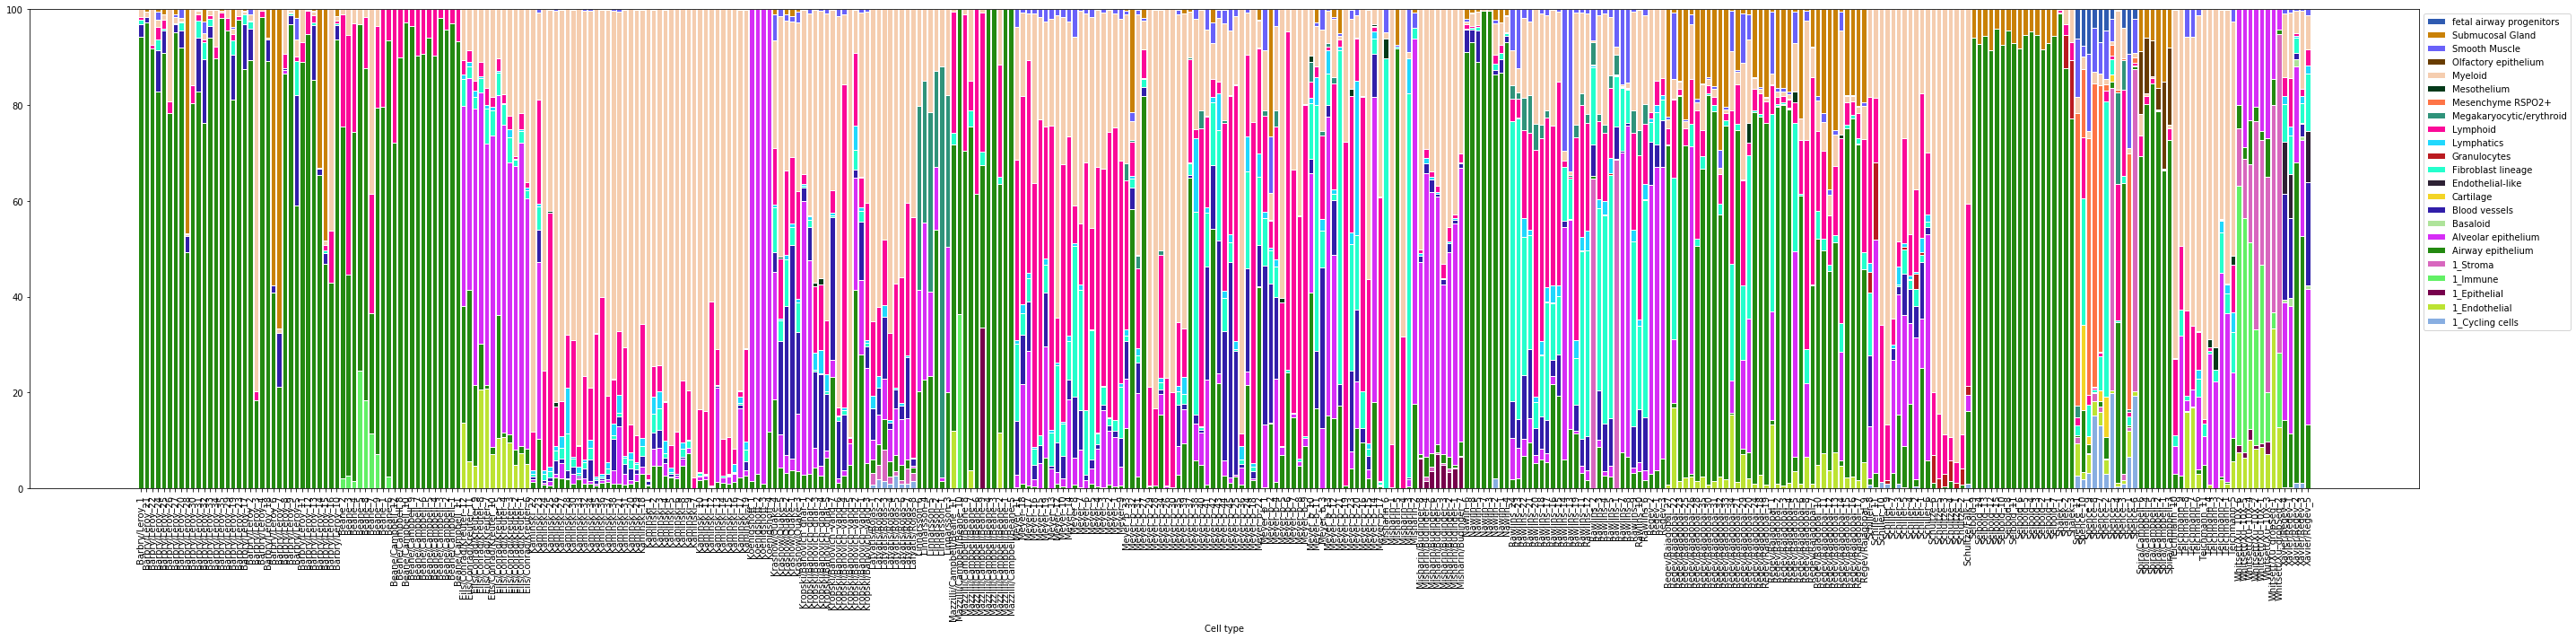

In [29]:
# Data
# convert dictionary to list
df = pd.DataFrame(raw_data)
df.index = samp_names
# store cell type names
ct_names = prop_dat_full_final.index.get_level_values(level=1).unique().tolist()

# From fraction to percentage
bars = dict()
for ct in ct_names:
    bars[ct] = [i * 100 for i in df[ct]]
# store one color per celltype as hex value
cols = cmap_24
# set bar width
barWidth = 0.85
# store x tick names
names = samp_names
# plot figure
plt.figure(figsize=(40, 10))
# start with the first celltype, and remove it from ct_names list
ct = ct_names.pop(0)
axs = []
# plot the bottom bars of the stacked bar chart using percentages of this cell type
axs.append(
    plt.bar(r, bars[ct], color=cols[0], edgecolor="white", width=barWidth, label=ct)
)
# store the bars under bars added, to know where next stack of bars should start
# in y-axis
bars_added = [bars[ct]]
# now loop through the remainder of the celltypes and plot
for i, ct in enumerate(ct_names):
    axs.append(
        plt.bar(
            r,
            bars[ct],
            bottom=[sum(idx_list) for idx_list in zip(*bars_added)],
            color=cols[i + 1],
            edgecolor="white",
            width=barWidth,
            label=ct,
        )
    )
    bars_added.append(bars[ct])
# Custom x axis
plt.xticks(r, names, rotation=90)
plt.xlabel("Cell type")
# Add a legend
plt.legend(
    axs[::-1],
    [ax.get_label() for ax in axs][::-1],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    ncol=1,
)
# Show graphic:
plt.show()

### cluster and visualize samples:

In [30]:
# store most prevalent cell type for each sample, for easier interpretation of the clusters:
# set ann_level_2 to list instead of categorical. That allows the "mode" function in 
# the grouping command below to work.
adata_full.obs.ann_level_2 = adata_full.obs.ann_level_2.tolist()
sample_celltype_mode_df = adata_full.obs.groupby("last_author_sample_name").agg(
    {"ann_level_2": pd.Series.mode}
)
sample_celltype_mode_dict = dict(
    zip(
        sample_celltype_mode_df.index.get_level_values(0),
        sample_celltype_mode_df.ann_level_2.values,
    )
)

In [31]:
# convert dataframe with cell type fractions per sample to an AnnData object for easier annotation
# and for easier processing (PCA, umap etc.)
ct_fraction_adata = sc.AnnData(df)
# add annotation specifying most prevalent celltype ("celltype_mode"):
ct_fraction_adata.obs["celltype_mode"] = ct_fraction_adata.obs.index.map(
    sample_celltype_mode_dict
)
# get lung_vs_nasal info from adata_full
ct_fraction_adata.obs["lung_vs_nasal"] = (
    adata_full.obs.groupby("last_author_sample_name")
    .agg({"last_author_sample_name": "first", "lung_vs_nasal": "first"})
    .set_index("last_author_sample_name")
    .loc[ct_fraction_adata.obs.index, :]
)
# get dataset info from adata_full
ct_fraction_adata.obs["dataset"] = (
    adata_full.obs.groupby("last_author_sample_name")
    .agg({"last_author_sample_name": "first", "last_author/PI": "first"})
    .set_index("last_author_sample_name")
    .loc[ct_fraction_adata.obs.index, :]
)

Inspection of sample clustering/separation: PCA

computing PCA with n_comps = 5
    finished (0:00:00)


... storing 'celltype_mode' as categorical
... storing 'lung_vs_nasal' as categorical
... storing 'dataset' as categorical
/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


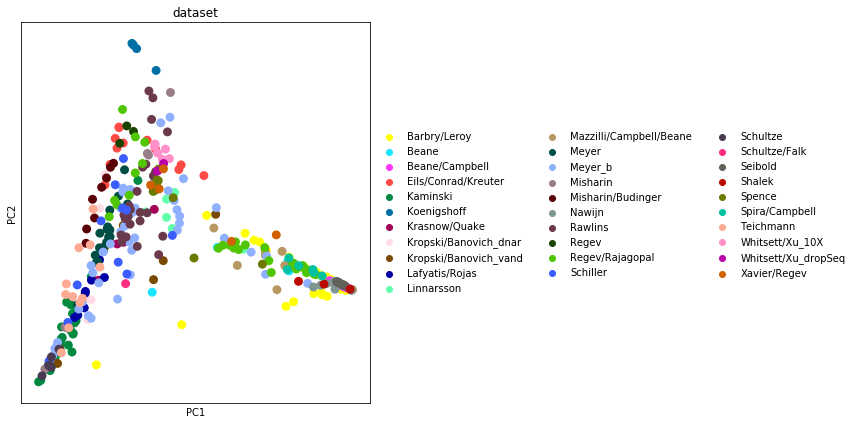

In [32]:
plt.rcParams["figure.figsize"] = (12, 6)
sc.pp.pca(ct_fraction_adata, svd_solver="arpack", n_comps=5)
sc.pl.pca(ct_fraction_adata, color="dataset")  # , size=100)
plt.rcParams["figure.figsize"] = (6, 6)

perform clustering

In [33]:
sc.pp.neighbors(ct_fraction_adata)
sc.tl.louvain(ct_fraction_adata, resolution=0.3, key_added="sample_clusters")

computing neighbors
    using data matrix X directly


/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/scanpy-1.4.5.post2.dev10+gfe8a584-py3.7.egg/scanpy/neighbors/__init__.py:104: DeprecationWarning: Use is_view instead of isview, isview will be removed in the future.
  if adata.isview:  # we shouldn't need this here...


    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 4 clusters and added
    'sample_clusters', the cluster labels (adata.obs, categorical) (0:00:00)


/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/scanpy-1.4.5.post2.dev10+gfe8a584-py3.7.egg/scanpy/neighbors/__init__.py:121: FutureWarning: This location for 'distances' is deprecated. It has been moved to .obsp[distances], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['distances'] = neighbors.distances
/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/scanpy-1.4.5.post2.dev10+gfe8a584-py3.7.egg/scanpy/neighbors/__init__.py:122: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'] = neighbors.connectivities
/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/scanpy-1.4.5.post2.dev10+gfe8a584-py3.7.egg/scanpy/tools/_louvain.py:108: FutureWarning: This location f

plot samples by pc coordinates and color by cluster:

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


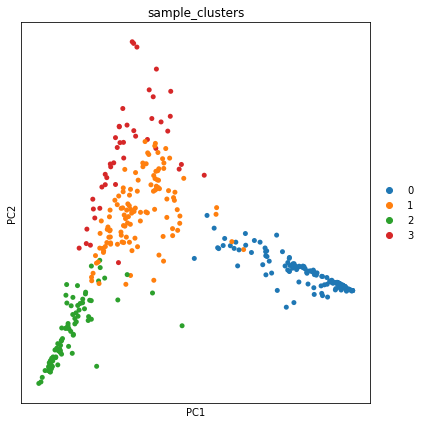

In [34]:
sc.pl.pca(ct_fraction_adata, color="sample_clusters", size=100)

print set of lung_vs_nasal annotations per cluster. This will most likely show that only one cluster contains nasal samples. This is the nasal/upper airway cluster

In [35]:
for cluster in sorted(set(ct_fraction_adata.obs.sample_clusters)):
    print(
        cluster,
        sorted(
            set(
                ct_fraction_adata.obs.loc[
                    ct_fraction_adata.obs.sample_clusters == cluster, "lung_vs_nasal"
                ]
            )
        ),
        "\n",
    )

0 ['lung', 'nasal'] 

1 ['lung'] 

2 ['lung'] 

3 ['lung'] 



make umap

In [36]:
sc.tl.umap(ct_fraction_adata)

computing UMAP


/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/scanpy-1.4.5.post2.dev10+gfe8a584-py3.7.egg/scanpy/tools/_umap.py:144: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  adata.uns['neighbors']['connectivities'].tocoo(),


    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


Now plot umap and color by 1) dataset; 2) cluster; 3) "celltype mode" (i.e. the most prevalent celltype annotation in the sample); and 4) lung_vs_nasal annotation. The two latter will likely explain the clustering, with nose and airway in one cluster, myeloid enriched samples in another, alveolar eptihelium enriched samples in a third, and mixed lung samples in a final cluster.

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


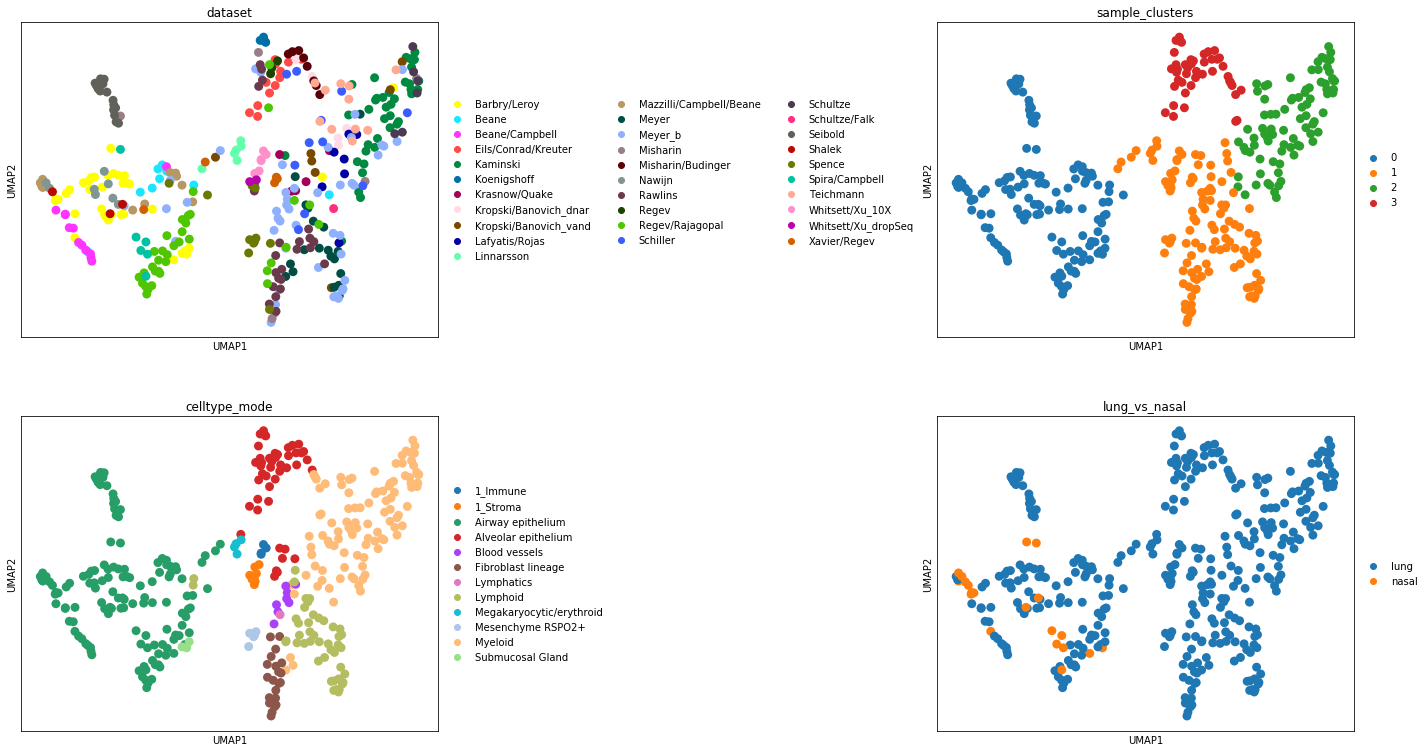

In [37]:
sc.pl.umap(
    ct_fraction_adata,
    color=["dataset", "sample_clusters", "celltype_mode", "lung_vs_nasal"],
    wspace=1.0,
    ncols=2,
)

make a dictionary with cluster numbers as keys, and matching sample names as values:

In [38]:
clusters = dict()
for clust in ct_fraction_adata.obs.sample_clusters.cat.categories:
    clusters[clust] = ct_fraction_adata.obs_names[
        ct_fraction_adata.obs.sample_clusters.isin([clust])
    ].tolist()

### Plot cell type composition bar plot, with samples sorted by cluster:

Reorder prop_data_full_final df, so that samples are ordered by cluster

In [39]:
# Reorder samples by cluster
samp_order = ct_fraction_adata.obs.sort_values(
    by="sample_clusters", ascending=True
).index.tolist()
# create new index order
index_order = [
    (i, j)
    for i in samp_order
    for j in prop_dat_full_final.index.get_level_values(level=1).unique()
]
# reorder prop_dat_full_final based on new index
prop_dat_full_final = prop_dat_full_final.loc[index_order]

store sample_names and matching numbers (0 to n_samples)

In [40]:
samp_names = samp_order
r = [i for i in range(len(samp_names))]

create dictionary with cell types as keys, and store all the matching proportions of that celltype (1 per sample) as value (in list form)

In [41]:
raw_data = {
    clust: prop_dat_full_final.iloc[
        prop_dat_full_final.index.get_level_values("ann_level_2") == clust
    ]
    .values.flatten()
    .tolist()
    for clust in np.unique(prop_dat_full_final.index.get_level_values("ann_level_2"))
}

now plot figure, with samples ordered by cluster

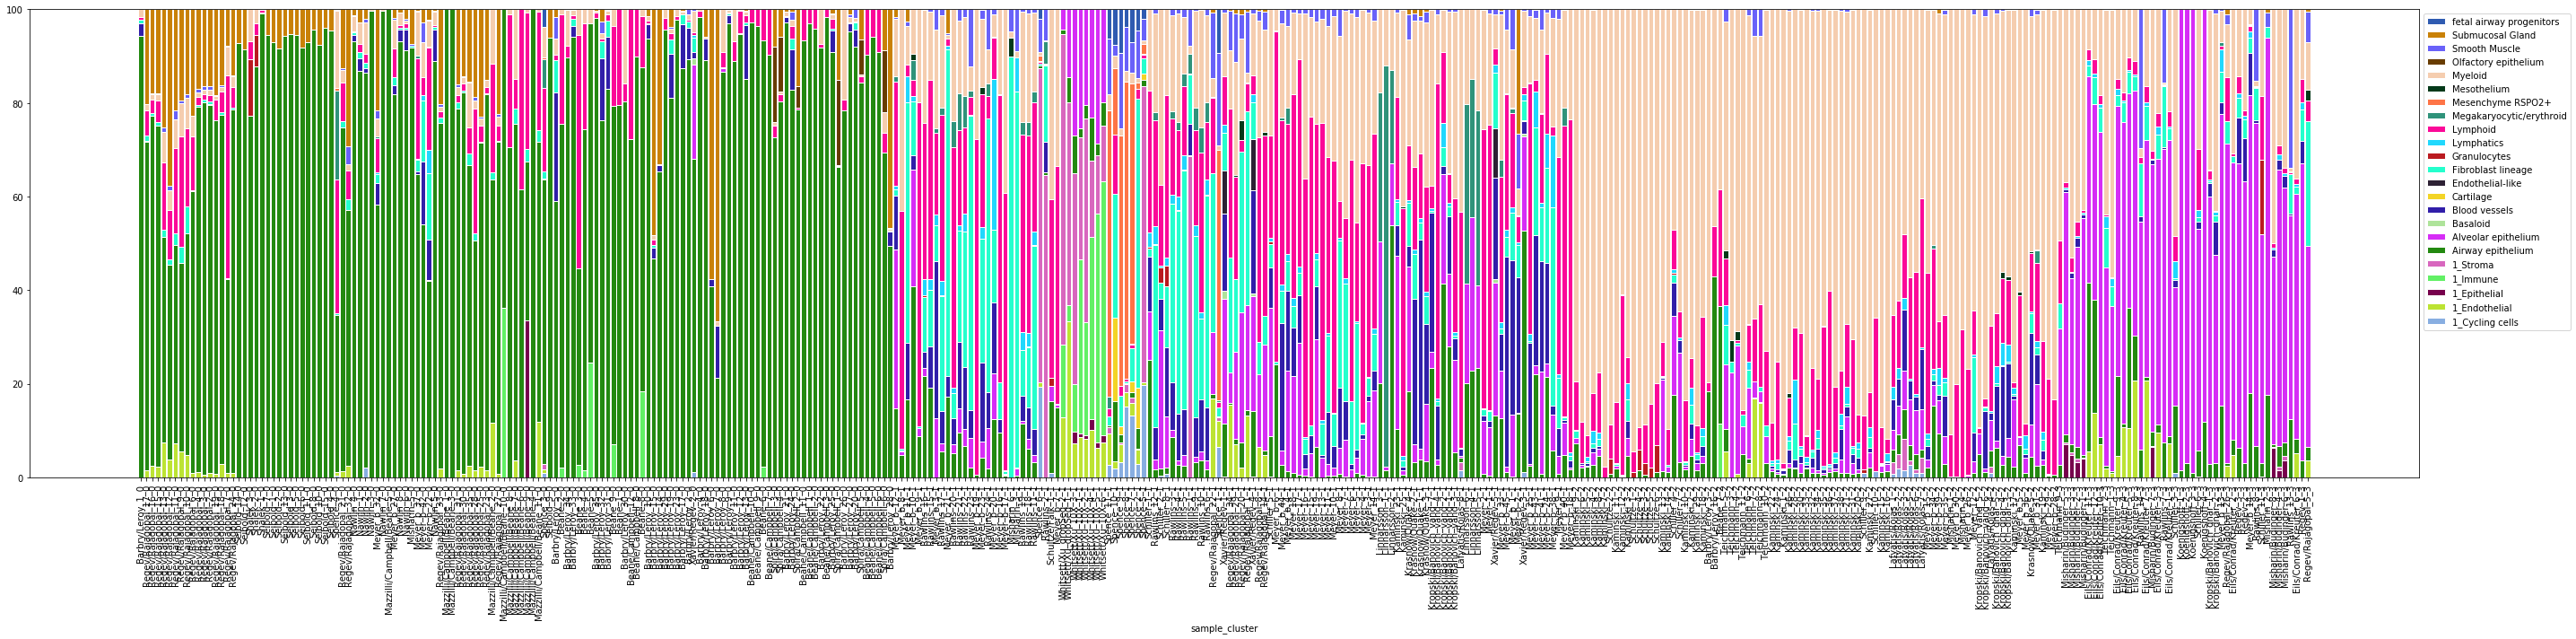

In [42]:
# Data
# convert dictionary to dataframe
df = pd.DataFrame(raw_data)
# store cell type names
ct_names = prop_dat_full_final.index.get_level_values(level=1).unique().tolist()
# From fraction to percentage
bars = dict()
for ct in ct_names:
    bars[ct] = [i * 100 for i in df[ct]]
# cols = [
#     colors.to_hex(sns.color_palette("tab20", len(ct_names))[i])
#     for i in range(len(ct_names))
# ]
# in case we need more than 20 colors, use customized cmap:
cols = cmap_24
# set barwidth and xtick names
barWidth = 0.85
names = samp_names
# plot figure
plt.figure(figsize=(40, 10))
# start with first celltype, remove it from the ct_names variable
ct = ct_names.pop(0)
axs = []
# plot its values as the bottom bars of the stacked bar chart
axs.append(
    plt.bar(r, bars[ct], color=cols[0], edgecolor="white", width=barWidth, label=ct)
)
# store bars in bars_added, so that we know where to place the next stack of bars
bars_added = [bars[ct]]
# now loop through remainder of cell types and plot their bars
for i, ct in enumerate(ct_names):
    axs.append(
        plt.bar(
            r,
            bars[ct],
            bottom=[sum(idx_list) for idx_list in zip(*bars_added)],
            color=cols[i + 1],
            edgecolor="white",
            width=barWidth,
            label=ct,
        )
    )
    bars_added.append(bars[ct])
# Custom x axis, add cluster number to x_tick labels so that we know where each
# cluster starts and ends
plt.xticks(
    r,
    [
        name + "_" + str(cluster)
        for name, cluster in zip(
            names, ct_fraction_adata.obs.loc[names, "sample_clusters"]
        )
    ],
    rotation=90,
)
plt.xlabel("sample_cluster")
# Add a legend
plt.legend(
    axs[::-1],
    [ax.get_label() for ax in axs][::-1],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    ncol=1,
)
# Store figure:
plt.savefig(
    folder + "/2A".format(ages),
    dpi=300,
    bbox_inches="tight",
)
# Show graphic:
plt.show()

## normalized ACE2 and TMPRSS2 expression per celltype, at single cell level (Fig. 2C)

Plot a violin plot of the normalized expression of ACE2 and TMPRSS2 per level-3 celltype, at single cell level. (Since we're plotting single cells here, it might take a while to plot!)

... storing 'ann_level_2' as categorical
... storing 'ann_level_3' as categorical
... storing 'adult_vs_fetal' as categorical
... storing 'age_string' as categorical
... storing 'simpl_annotation' as categorical
/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/seaborn/categorical.py:827: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  val = np.asscalar(support)
/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/seaborn/categorical.py:828: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  d = np.asscalar(density)


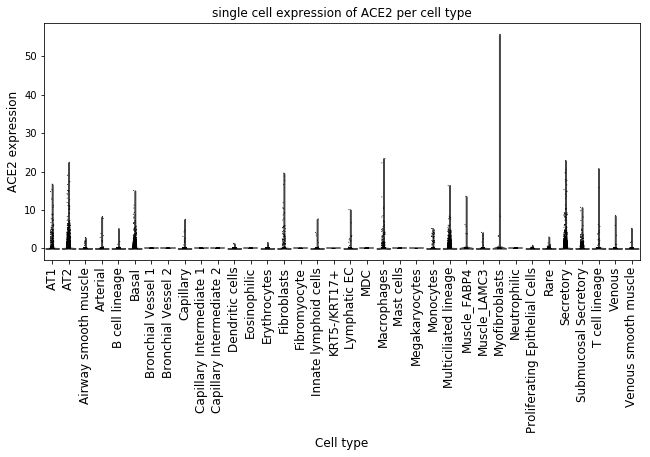

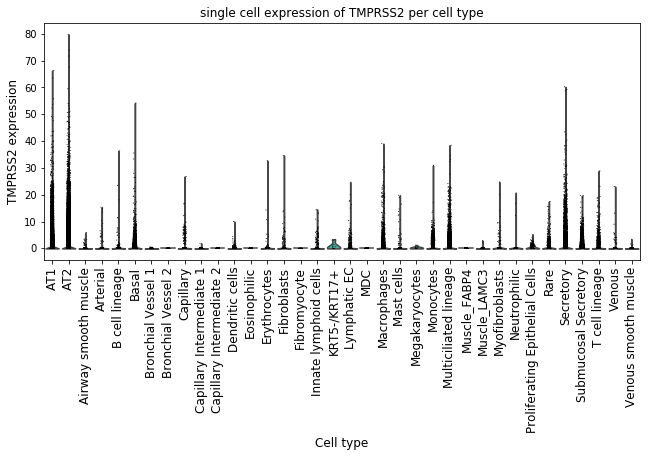

In [43]:
# select only cells that have a level-3 annotation
fontsize = 12
adata_sub = adata_full[
    [
        (not ct.startswith("1")) and (not ct.startswith("2")) and (ct != "None")
        for ct in adata_full.obs.ann_level_3
    ],
].copy()
rcParams["figure.figsize"] = (9, 4.5)  # (16, 8)
# ACE2
p1 = sc.pl.violin(
    adata_sub, keys="ACE2_norm", groupby="ann_level_3", show=False, frameon=False,
)
tmp = p1.set_xticklabels(p1.get_xticklabels(), rotation=90, fontsize=fontsize)
# tmp = p1.set_yticklabels(p1.get_yticklabels(), fontsize=fontsize)
tmp = p1.set_ylabel("ACE2 expression", fontsize=fontsize)
tmp = p1.set_xlabel("Cell type", fontsize=fontsize)
tmp = p1.set_title("single cell expression of ACE2 per cell type")
plt.tight_layout()
plt.savefig(folder + "/2c_ACE2_expr.pdf", dpi=300, bbox_inches="tight")
plt.show()
# TMPRSS2
p1 = sc.pl.violin(
    adata_sub, keys="TMPRSS2_norm", groupby="ann_level_3", show=False, frameon=False
)
tmp = p1.set_xticklabels(p1.get_xticklabels(), rotation=90, fontsize=fontsize)
# tmp = p1.set_yticklabels(p1.get_yticklabels(), fontsize=fontsize)
tmp = p1.set_ylabel("TMPRSS2 expression", fontsize=fontsize)
tmp = p1.set_xlabel("Cell type", fontsize=fontsize)
tmp = p1.set_title("single cell expression of TMPRSS2 per cell type")
plt.tight_layout()
plt.savefig(folder + "/2c_TMPRSS2_expr.pdf", dpi=300, bbox_inches="tight")
plt.show()
rcParams["figure.figsize"] = (8, 8)

## Boxplot showing overal dp fractions per celltype (ED Fig. 3a)

calculate total cell type counts per celltype, per donor:

In [44]:
donor_ct_counts = pd.DataFrame(
    adata_full.obs.groupby(["donor"]).simpl_annotation.value_counts()
).unstack("simpl_annotation")
donor_ct_counts.columns = donor_ct_counts.columns.droplevel(0)

calculate median total counts per celltype, per donor (we'll need this for normalization later)

In [45]:
donor_ct_median_umi = (
    adata_full.obs.groupby(["donor", "simpl_annotation"])
    .agg({"total_counts": "median"})
    .unstack("simpl_annotation")
)
donor_ct_median_umi.columns = donor_ct_median_umi.columns.droplevel(0)

calculate number of dp cells per cell type, per donor:

In [46]:
dp_donor_ct_counts = pd.DataFrame(
    adata_dp_full.obs.groupby(["donor"]).simpl_annotation.value_counts()
).unstack("simpl_annotation")
dp_donor_ct_counts.columns = dp_donor_ct_counts.columns.droplevel(0)

make sure that all donors and all cell types are present in all three dataframes, in the same order:

In [47]:
donors = sorted(set(adata_full.obs["donor"]))
celltypes = sorted(set(adata_full.obs.simpl_annotation))
celltypes.append(celltypes.pop(celltypes.index("Other")))  # Move "Other" to end of list
donor_ct_counts = donor_ct_counts.reindex(index=donors, columns=celltypes)
donor_ct_median_umi = donor_ct_median_umi.reindex(index=donors, columns=celltypes)
dp_donor_ct_counts = dp_donor_ct_counts.reindex(index=donors, columns=celltypes).fillna(
    0
)

now calculate fractions of dps, by dividing number of dps by number of cells:

In [48]:
dp_fractions_donor = dp_donor_ct_counts / donor_ct_counts

and normalize for median total count in the group of cells (cells with higher total counts are also expected to have more dps, since gene detection rate is higher)

In [49]:
dp_fractions_donor_norm = dp_fractions_donor / donor_ct_median_umi * 10 ** 4

exclude values of donor-celltype pairs if donor has fewer than 100 cells of the celltype

In [50]:
# create boolean mask, that sets only donor-ct pairs with fewer than 100 cells to true
min_n_cells = 100
donor_ct_mask = donor_ct_counts < min_n_cells

set all dp_fractions that fail the mask filter to NaN

In [51]:
dp_fractions_donor_norm_masked = dp_fractions_donor_norm.mask(donor_ct_mask)

Color preparation:  
Create a custom colormap that has easily distinguishable colors and has grey at the end (the 'Other' category). If ann level is 3, use the colors as they were used in the paper:

To reproduce the colors from the paper figure, we stored the level 3 labels and matching colors in a separate dict here:

In [52]:
level3_label_to_color_dict = {
    "1_Endothelial": "#a6cee3",
    "2_Airway epithelium": "#1f78b4",
    "2_Olfactory epithelium": "#b2df8a",
    "2_fetal airway progenitors": "#33a02c",
    "AT1": "#fb9a99",
    "AT2": "#e31a1c",
    "Basal": "#fdbf6f",
    "Multiciliated lineage": "#ff7f00",
    "Secretory": "#cab2d6",
    "Submucosal Secretory": "#6a3d9a",
    "Other": "#858585",
}

In [53]:
# get celltype names
ct_names = sorted(adata_dp_full.obs.simpl_annotation.unique().tolist())
# move 'Other' to end of list
ct_names = [ct for ct in ct_names if ct != "Other"]
# only add Other for levels higher than 1
if level != 1:
    ct_names.append("Other")

In [54]:
if level_name == "ann_level_3":
    custom_cmap = [level3_label_to_color_dict[label] for label in ct_names]
else:
    n_colors = len(set(adata_full.obs.simpl_annotation))
    # change colormap to your liking here:
    custom_cmap = [
        colors.to_hex(sns.color_palette("tab20", n_colors)[i])
        for i in range(n_colors - 1)
    ] + [
        "#858585"
    ]  # add grey to the end, this will be the 'other' category

and generate boxplot, showing normalized celltype dp fractions

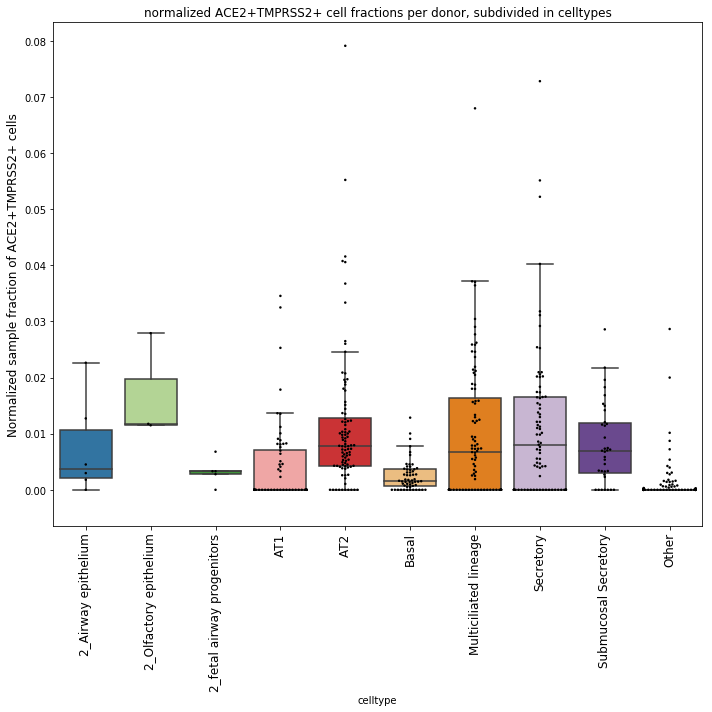

In [55]:
fig = plt.figure(figsize=(10, 10))
ax = sns.swarmplot(
    # use only columns that are also in celltype_stats_df (i.e. exclude columns that have no data points, only None)
    data=dp_fractions_donor_norm_masked,
    color="black",  # ".25",
    size=2.5,
)
ax = sns.boxplot(
    data=dp_fractions_donor_norm_masked,
    palette=custom_cmap,  # "tab20",
    # don't show outliers, since they're already shown by the swarmplot
    showfliers=False,
)
plt.title("normalized ACE2+TMPRSS2+ cell fractions per donor, subdivided in celltypes")
plt.ylabel("Normalized sample fraction of ACE2+TMPRSS2+ cells", fontsize=12)
plt.xlabel("celltype")
plt.xticks(rotation=90, fontsize=12)
plt.savefig(
    folder + "/ed3a.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()
plt.close()

In [56]:
# list number of donors included for every celltype:
ct_donor_numbers = np.sum(donor_ct_counts >= min_n_cells, axis=0)
for i in ct_donor_numbers.index:
    print(i, ct_donor_numbers[i])

2_Airway epithelium 6
2_Olfactory epithelium 3
2_fetal airway progenitors 5
AT1 60
AT2 92
Basal 56
Multiciliated lineage 88
Secretory 79
Submucosal Secretory 35
Other 180


## Barplot showing perc. of double positive cells, broken down in cell types (ED Fig. 3b/c, top)

set ages variable in code above to "all" for 3b, and "young" for 3c

calculate fraction of double positive cells per sample:

In [57]:
# store the total double positive fraction per sample in a separate dataframe
dp_frac_scaled = adata_full.obs.groupby("last_author_sample_name").agg(
    {"doub_pos": "mean"}
)

calculate number of dp cells of each cell type, in each sample

In [58]:
dp_sample_ct_counts = pd.DataFrame(
    adata_dp_full.obs.groupby(
        ["last_author_sample_name"]
    ).simpl_annotation.value_counts()
)

now convert these cell numbers to fractions (i.e. fraction of a specific cell type's dps over all dps, in a specific sample)

In [59]:
prop_dat = dp_sample_ct_counts.groupby(level=0).apply(lambda x: x / float(x.sum()))

reindex the celltype proportion df, so that for each sample, all cell types are listed (two-level index). Cell types that are not present in the sample are set to 0

In [60]:
new_index = pd.MultiIndex.from_product(
    [
        adata_full.obs["last_author_sample_name"].cat.categories.tolist(),
        prop_dat.index.levels[1].tolist(),
    ]
)
prop_dat_final = prop_dat.reindex(new_index).fillna(0)

Use dp_frac_scaled (fraction of double positive cells per sample) and prop_dat_final (proportions of cell types within dp section) to get proportions of double positives per cell type, over the _entire sample_ instead of over only the double positive subpart. These will be stored in prop_dat_final_scaled

In [61]:
multiplier = [
    dp_frac_scaled.loc[samp].tolist()[0]
    for samp in prop_dat_final.index.get_level_values(level=0)
]

In [62]:
prop_dat_final_scaled = prop_dat_final.copy()
prop_dat_final_scaled["simpl_annotation"] = (
    prop_dat_final["simpl_annotation"].values * multiplier
)

Reorder the resulting dataframe by age, and sort cell type indices the same way for every sample (second level of the index)

In [63]:
# Reorder samples by age
samp_order = (
    adata_full.obs.groupby(["last_author_sample_name"])
    .agg({"age": "first", "age_string": "first"})
    .sort_values(by=["age", "age_string"], ascending=True)
    .index.tolist()
)
# also keep order of celltypes in second index level constant
index_order = [
    (i, j)
    for i in samp_order
    for j in prop_dat_final_scaled.index.get_level_values(level=1).unique()
]

prop_dat_final_scaled = prop_dat_final_scaled.loc[index_order]

store the sample names and a matching variable with a number range (0 to n_samples):

In [64]:
samp_names = prop_dat_final_scaled.index.get_level_values(level=0).unique()
r = [i for i in range(len(samp_names))]

create a dictionary with celltypes as keys, and a list of matching proportions per sample as values

In [65]:
raw_data = {
    clust: prop_dat_final_scaled.iloc[
        prop_dat_final_scaled.index.get_level_values(level=1) == clust
    ]
    .values.flatten()
    .tolist()
    for clust in np.unique(prop_dat_final_scaled.index.get_level_values(level=1))
}

Now plot a stacked bar chart figure, showing the percentage of double positive cells per sample, broken up in cell types

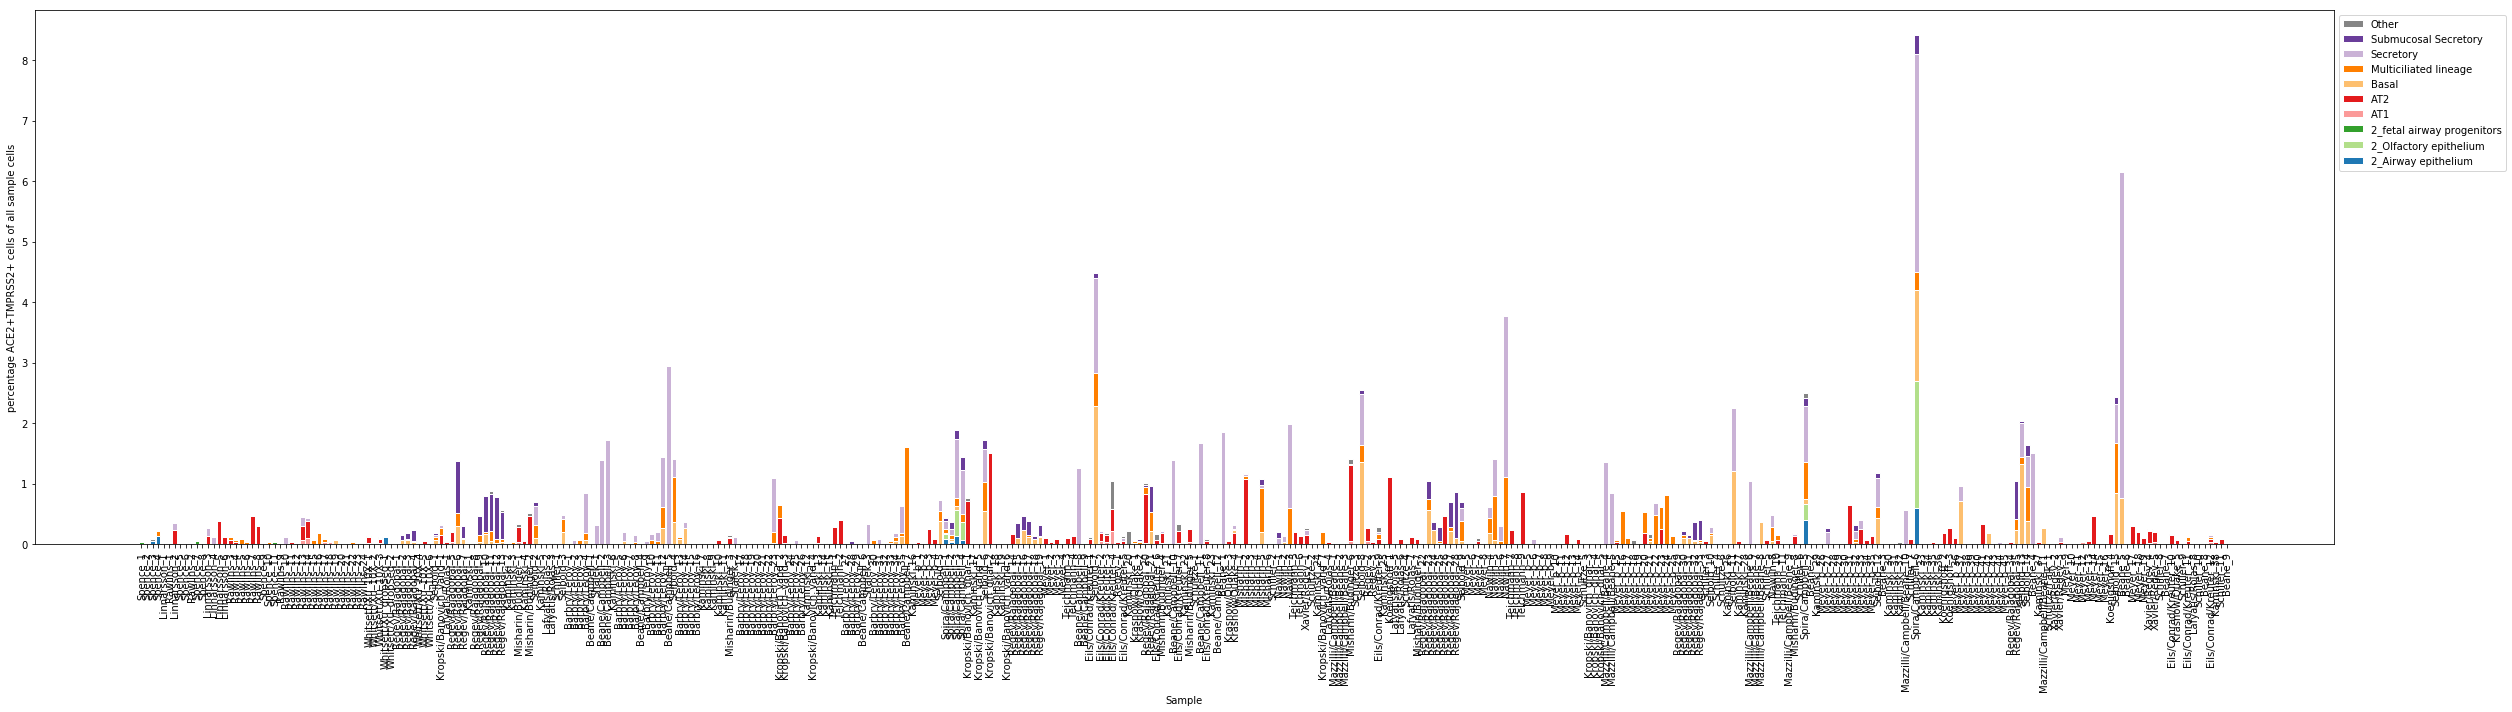

In [66]:
# Plot
# convert dictionary to dataframe
df = pd.DataFrame(raw_data)

# From raw value to percentage
# calculate the total double postive fraction per sample
totals = [sum(i_list) for i_list in zip(*[df[i] for i in ct_names])]
# now store, per celltype, the height of the "sub-bar" for each sample
# (calculated in percentage)
bars = dict()
for ct in ct_names:
    bars[ct] = [i * 100 for i in df[ct]]
# store one color per celltype as hex value in cols list
cols = custom_cmap
# set barwidth, names for x ticks
barWidth = 0.85
names = samp_names  # ['D'+str(i+1) for i in range(len(samp_names))]
# plot figure
plt.figure(figsize=(35, 10))
# start with the bottom bars (since we're plotting a stacked bar chart here)
# start at first cell type and remove it from the cell type list (pop function):
ct = ct_names.pop(0)
axs = []
axs.append(
    plt.bar(r, bars[ct], color=cols[0], edgecolor="white", width=barWidth, label=ct)
)
bars_added = [bars[ct]]
# now loop throught the remainder of cell types, and plot their bar on top of
# the previous:
for i, ct in enumerate(ct_names):
    axs.append(
        plt.bar(
            r,
            bars[ct],
            bottom=[sum(idx_list) for idx_list in zip(*bars_added)],
            color=cols[i + 1],
            edgecolor="white",
            width=barWidth,
            label=ct,
        )
    )
    bars_added.append(bars[ct])
# Custom x axis
plt.xticks(r, names, rotation=90)
plt.xlabel("Sample")
plt.ylim((0, 1.05 * (max(totals) * 100)))
plt.ylabel("percentage ACE2+TMPRSS2+ cells of all sample cells")
# Add a legend
plt.legend(
    axs[::-1],
    [ax.get_label() for ax in axs][::-1],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    ncol=1,
)

# Save figure:
plt.savefig(
    folder + "/ed3_{}_ages_top.pdf".format(ages),
    dpi=300,
    bbox_inches="tight",
)
# Show figure:
plt.show()
plt.close()

## Barplot showing cell type composition per sample (ED Fig. 3b/c, bottom)

store cell numbers per sample (index) per cell type (column) in a dataframe:

In [67]:
sample_ct_counts = pd.DataFrame(
    adata_full.obs.groupby(["last_author_sample_name"]).simpl_annotation.value_counts()
)

now convert cell numbers to proportions, totaling to 1 in every sample (i.e. row)

In [68]:
prop_dat_full = sample_ct_counts.groupby(level=0).apply(lambda x: x / float(x.sum()))
# make sure that every cell type is represented in every sample:
# df has two-level index, with for every sample, every cell type as an index
new_index = pd.MultiIndex.from_product(prop_dat_full.index.levels)
# fill cell types that were not present in sample with 0
prop_dat_full_final = prop_dat_full.reindex(new_index).fillna(0)
# name the second level index:
prop_dat_full_final.index.set_names("simpl_annotation", level=1, inplace=True)

order second level indices (cell type) of df:

In [69]:
# Store cell types in list, and remove "Other"
ct_order = sorted(
    [ct for ct in adata_full.obs.simpl_annotation.unique() if ct != "Other"]
)  # in cell_types
# Now append "Other", so that it is at the end of the list
if level != 1:  # for levels higher than level 1, add 'Other'
    ct_order.append("Other")
# for level 1, only add other if not all cell type labels are already included:
elif level == 1 and set(adata_full.obs[level_name]) != set(ct_order):
    ct_order.append("Other")

# order indices of prop_dat_full_final, so that cell type order is
# the same for every sample
index_order = [
    (i, j)
    for i in prop_dat_full_final.index.get_level_values(level=0).categories
    for j in ct_order
]
# reorder df
prop_dat_full_final = prop_dat_full_final.loc[index_order]

order first level indices (sample) of df by age:

In [70]:
# Reorder samples by age
samp_order = (
    adata_full.obs.groupby(["last_author_sample_name"])
    .agg({"age": "first", "age_string": "first"})
    .sort_values(by=["age", "age_string"], ascending=True)
    .index.tolist()
)

index_order = [
    (i, j)
    for i in samp_order
    for j in prop_dat_full_final.index.get_level_values(level=1).unique()
]

prop_dat_full_final = prop_dat_full_final.loc[index_order]

store sample names in separate variable, and matching range list (0 to n_samples)

In [71]:
samp_names = prop_dat_full_final.index.get_level_values(level=0).unique()
r = [i for i in range(len(samp_names))]

create a dictionary with cell types as keys, and a list of cell type proportions (one per sample) as values:

In [72]:
raw_data = {
    clust: prop_dat_full_final.iloc[
        prop_dat_full_final.index.get_level_values("simpl_annotation") == clust
    ]
    .values.flatten()
    .tolist()
    for clust in np.unique(
        prop_dat_full_final.index.get_level_values("simpl_annotation")
    )
}

now plot a stacked bar chart, showing cell type composition for every sample (ordered by age):

In [73]:
# get celltype names
ct_names = prop_dat_full_final.index.get_level_values(level=1).unique().tolist()
# move 'Other' to end of list
ct_names = [ct for ct in ct_names if ct != "Other"]
# only add Other for levels higher than 1
if level != 1:
    ct_names.append("Other")

In [74]:
if level_name == "ann_level_3":
    custom_cmap = [level3_label_to_color_dict[label] for label in ct_names]
else:
    n_colors = len(set(adata_full.obs.simpl_annotation))
    # change colormap to your liking here:
    custom_cmap = [
        colors.to_hex(sns.color_palette("tab20", n_colors)[i])
        for i in range(n_colors - 1)
    ] + [
        "#858585"
    ]  # add grey to the end, this will be the 'other' category

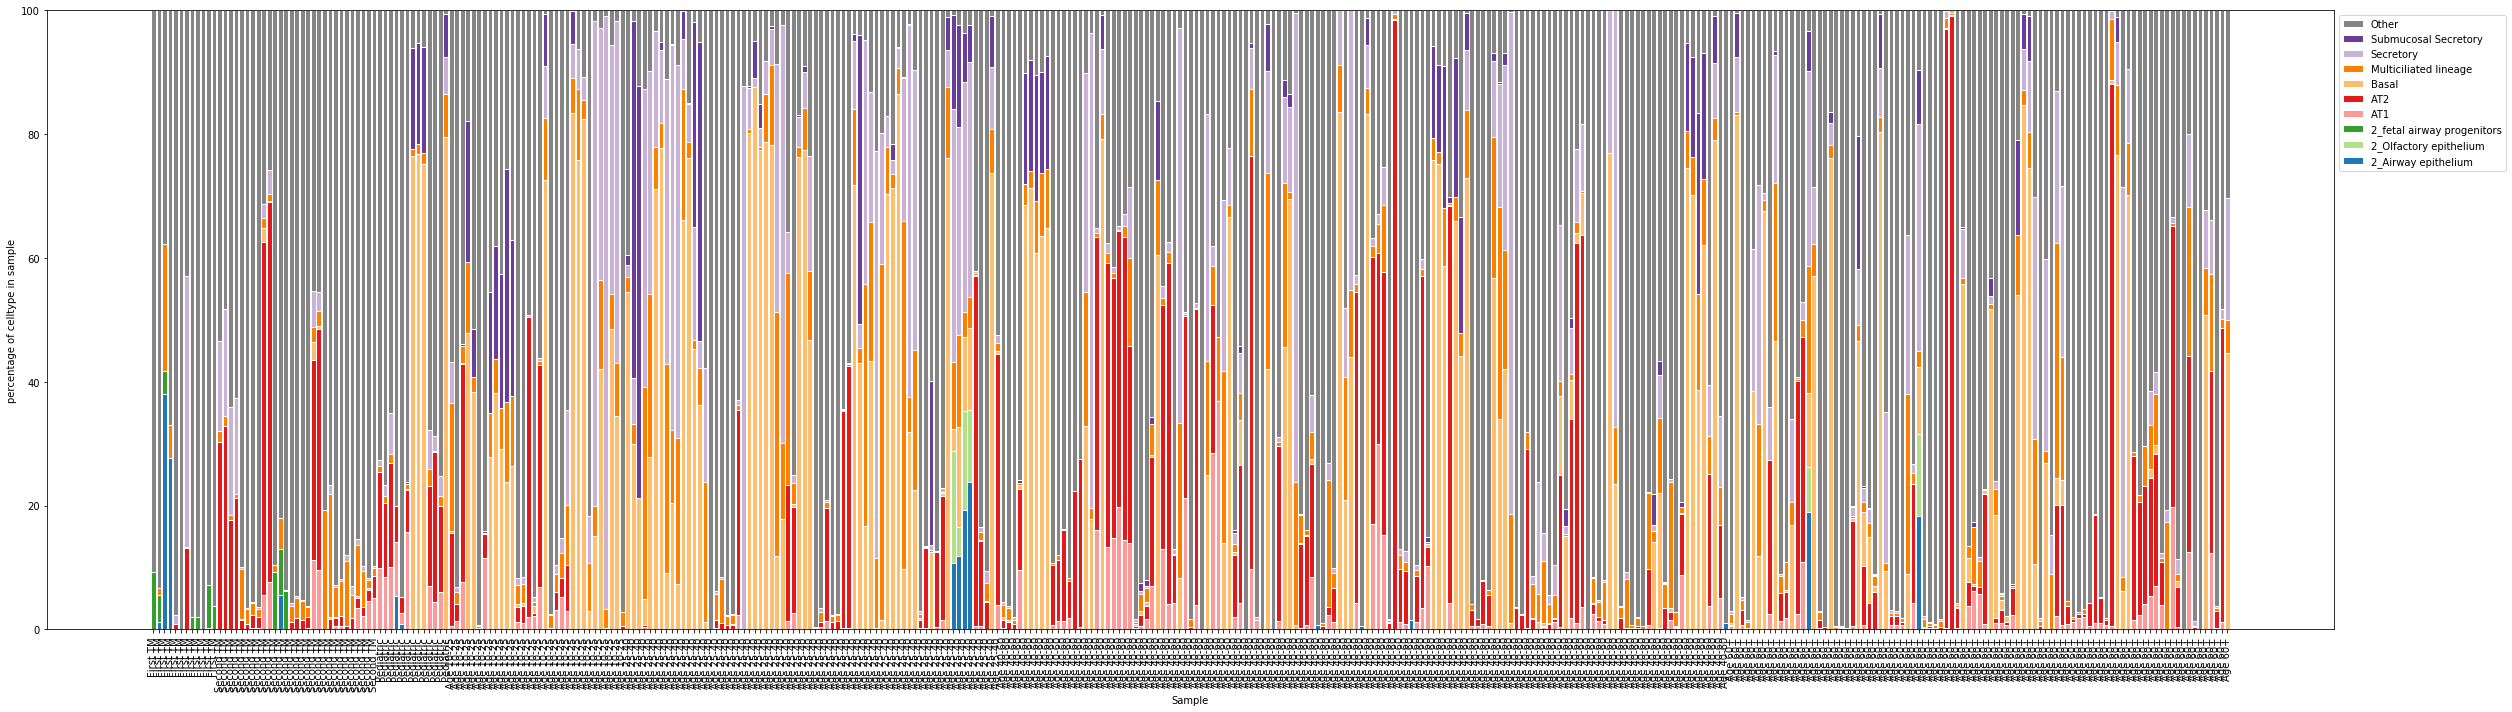

In [75]:
# Data
# convert dictionary to dataframe
df = pd.DataFrame(raw_data)
# for each cell type, store the percentage of the cell type for each sample
# in a dict with cell types as keys, and list of percentages as values
bars = dict()
for ct in ct_names:
    bars[ct] = [i * 100 for i in df[ct]]
# store one color for each cell type as hex value:
cols = custom_cmap
# set bar width
barWidth = 0.85
# set names for x ticks (for young plot, we'll use group name)
if ages == "all":
    samp_mapping = (
        adata_full.obs.groupby(["last_author_sample_name"])
        .agg({"last_author_sample_name": "first", "age_bins": "first"})
        .set_index("last_author_sample_name")
    )
    names = [samp_mapping.loc[i]["age_bins"] for i in samp_names]
elif ages == "young":
    samp_mapping = (
        adata_full.obs.groupby(["last_author_sample_name"])
        .agg({"last_author_sample_name": "first", "age_string": "first"})
        .set_index("last_author_sample_name")
    )
    names = [samp_mapping.loc[i]["age_string"] for i in samp_names]
# plot figure
plt.figure(figsize=(35, 10))
# plot the bottom bars of the stacked bar chart:
# select the first cell type and remove it from the ct_names list
ct = ct_names.pop(0)
axs = []
# plot the matching bars
axs.append(
    plt.bar(r, bars[ct], color=cols[0], edgecolor="white", width=barWidth, label=ct)
)
# store plotted bars under bars_added (to know where next set of bars should
# start on the y-axis)
bars_added = [bars[ct]]
# now loop through remainder of cell types and plot bars on top of previous bars
for i, ct in enumerate(ct_names):
    axs.append(
        plt.bar(
            r,
            bars[ct],
            bottom=[sum(idx_list) for idx_list in zip(*bars_added)],
            color=cols[i + 1],
            edgecolor="white",
            width=barWidth,
            label=ct,
        )
    )
    bars_added.append(bars[ct])
# Custom x axis
plt.xticks(r, names, rotation=90)
plt.xlabel("Sample")
plt.ylabel("percentage of celltype in sample")
# Add a legend
plt.legend(
    axs[::-1],
    [ax.get_label() for ax in axs][::-1],
    loc="upper left",
    bbox_to_anchor=(1, 1),
    ncol=1,
)
# Store figure
plt.savefig(
    folder + "/ed3_{}_ages_bottom.pdf".format(ages),
    dpi=300,
    bbox_inches="tight",
)
# Show graphic
plt.show()
plt.close()

## Heatmap with sample/celltype proportions of double positives (Suppl. Fig. 15)

We list the annotations of all three levels here, _ordered by cell compartment_ (as they appear in the supplementary tables), for easier interpretation of the figure

In [76]:
ordered_anns = dict()

In [77]:
ordered_anns["ann_level_1"] = [
    "Epithelial",
    "Endothelial",
    "Stroma",
    "Immune",
    "Cycling cells",
    "New",
    "Unicorns and artifacts",
]
ordered_anns["ann_level_2"] = [
    "fetal airway progenitors",
    "Airway epithelium",
    "Submucosal Gland",
    "Alveolar epithelium",
    "Olfactory epithelium",
    "Basaloid",
    "Blood vessels",
    "Lymphatics",
    "Endothelial-like",
    "Fibroblast lineage",
    "Smooth Muscle",
    "Mesothelium",
    "Cartilage",
    "Mesenchyme RSPO2+",
    "Lymphoid",
    "Myeloid",
    "Granulocytes",
    "Megakaryocytic/erythroid",
]
ordered_anns["ann_level_3"] = [
    "Basal",
    "Multiciliated lineage",
    "Secretory",
    "Rare",
    "Epithelial cells, proliferating",
    "KRT5-/KRT17+",
    "Submucosal Secretory",
    "Acinar",
    "AT1",
    "AT2",
    "Arterial",
    "Capillary",
    "Venous",
    "Bronchial Vessel 1",
    "Bronchial Vessel 2",
    "Capillary Intermediate 1",
    "Capillary Intermediate 2",
    "Lymphatic EC",
    "Fibroblasts",
    "Myofibroblasts",
    "SC85_C15_SMC",
    "SC86_C7_SM_1",
    "SC86_C17_SM_2",
    "SC86_C18_SM_3",
    "SC89_C8_SM",
    "SC88_C22_SMC",
    "Airway smooth muscle",
    "Venous smooth muscle",
    "Fibromyocyte",
    "Muscle_FABP4",
    "Muscle_LAMC3",
    "SC89_C11_Mesothelial_2_DEFB4A",
    "B cell lineage",
    "T cell lineage",
    "Innate lymphoid cells",
    "Dendritic cells",
    "Macrophages",
    "Monocytes",
    "MDC",
    "Mast cells",
    "Basophilic",
    "Neutrophilic",
    "Eosinophilic",
    "Megakaryocytes",
    "Erythrocytes",
]

choose the level to work with:

In [78]:
level = 3
level_name = "ann_level_" + str(level)

only include cell types that appear in at least n=3 samples:

In [79]:
min_samples = 3
ct_sample_count = adata_full.obs.groupby(level_name).agg(
    {"last_author_sample_name": "nunique"}
)
preval_anns = ct_sample_count.loc[
    ct_sample_count["last_author_sample_name"] >= min_samples, :
].index
anns_to_include = [ann for ann in ordered_anns[level_name] if ann in preval_anns]

we want to order datasets by median age, and samples within dataset by age, to see if any age trend can be visually seen. We will here order datasets:

In [80]:
# get dictionary ordering datasets by median age:
donor_dataset_age_df = adata_full.obs.groupby("donor").agg(
    {"age": "first", "last_author/PI": "first"}
)
donor_dataset_age_df = donor_dataset_age_df.groupby("last_author/PI").agg(
    {"age": "median"}
)
datasets_ordered = donor_dataset_age_df.sort_values(by="age").index
dataset_order_number_dict = dict([(y, x) for x, y in enumerate(datasets_ordered)])

now order samples, by dataset (ordered by age), and then within dataset by age. Together with ordered samples, get matching sample ages:

In [81]:
sample_ordering_df = adata_full.obs.groupby("last_author_sample_name").agg(
    {"last_author/PI": "first", "age": "first", "donor": "first"}
)
# now translate datasets to numbers for easier ordering:
sample_ordering_df["dataset_order_number"] = (
    sample_ordering_df["last_author/PI"].map(dataset_order_number_dict).tolist()
)
# and order samples:
sample_ordering_df.sort_values(
    by=["dataset_order_number", "age", "donor", "last_author_sample_name"],
    inplace=True,
)
samples_ordered = sample_ordering_df.index.tolist()
ages_ordered = sample_ordering_df["age"].tolist()
datasets_ordered = sample_ordering_df["last_author/PI"]

calculate double positive fractions per sample, per cell type:

In [82]:
sample_ct_dp_fractions = (
    adata_full.obs.groupby(["last_author_sample_name", level_name])
    .agg({"doub_pos": "mean"})
    .unstack()
)
# drop second level of multi-index created:
sample_ct_dp_fractions.columns = sample_ct_dp_fractions.columns.droplevel(0)
# order rows by sample order, and take only columns of ann levels to include
sample_ct_dp_fractions = sample_ct_dp_fractions.loc[samples_ordered, anns_to_include]

calculate median total count per sample, per cell type:

In [83]:
sample_ct_total_counts = (
    adata_full.obs.groupby(["last_author_sample_name", level_name])
    .agg({"total_counts": "median"})
    .unstack()
)
# drop second level of multi-index created:
sample_ct_total_counts.columns = sample_ct_total_counts.columns.droplevel(0)
# order rows by sample order, and take only columns of ann levels to include
sample_ct_total_counts = sample_ct_total_counts.loc[samples_ordered, anns_to_include]

normalize dp fractions to a median total count of 10**4 UMIs per cell:

In [84]:
sample_ct_norm_dp_fractions = sample_ct_dp_fractions / sample_ct_total_counts * 10 ** 4

x axis color bar:

In [85]:
# create colormap for columns, related to dataset:
# network_pal = sns.color_palette("colorblind", len(datasets.unique()))
# dataset_to_color = dict(zip(datasets.unique(), network_pal))
dataset_to_color = dict(
    zip(
        datasets_ordered.unique(),
        ["grey", "black"] * int(np.ceil(len(datasets_ordered.unique()) / 2)),
    )
)
x_bar_colors_dataset = pd.Series(list(datasets_ordered)).map(dataset_to_color).values

plot age barplot, that matches the sample order of the heatmap that will be created below (in the paper, these two figures are merged)

/home/icb/lisa.sikkema/miniconda3/envs/scRNAseq_analysis_backup/lib/python3.7/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


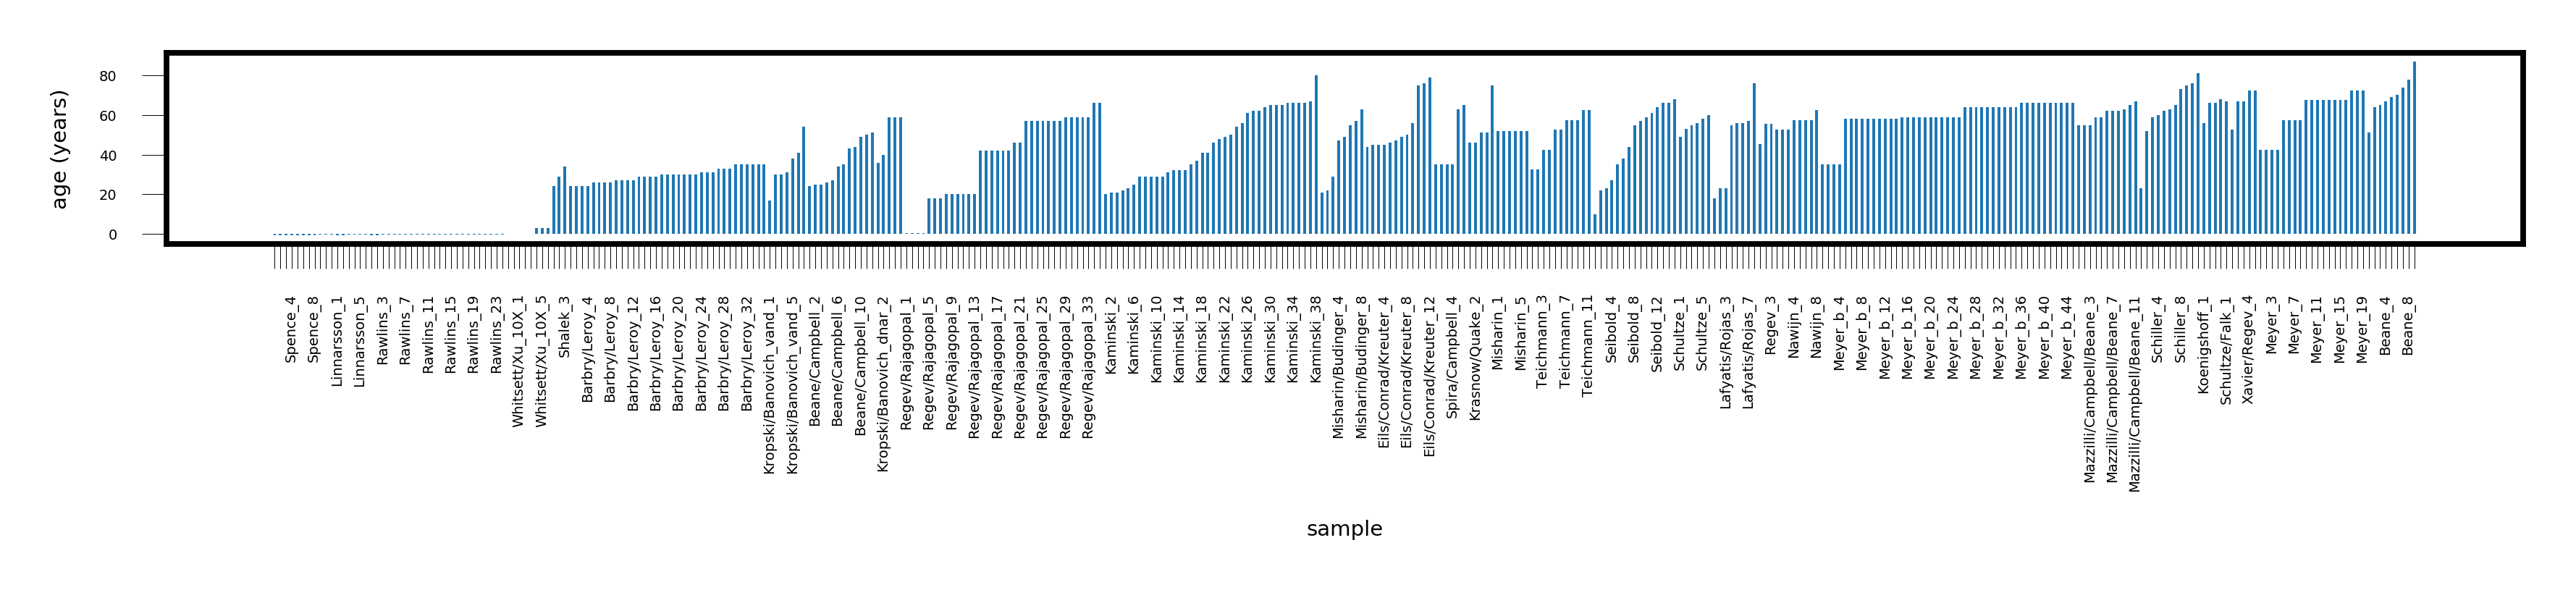

In [86]:
plt.rcParams["figure.dpi"] = 700
fig = plt.figure(figsize=(6, 0.5))
ax = fig.add_subplot(1, 1, 1)
ax.bar(
    samples_ordered, ages_ordered, width=0.5,
)
step_size = 4
x_ticks_new = samples_ordered.copy()
for i in range(0, step_size - 1):
    x_ticks_new[i::step_size] = len(x_ticks_new[i::step_size]) * [""]
ax.set_xticklabels(x_ticks_new, rotation=90, fontsize=2)
loc = pltticker.MultipleLocator(
    base=20.0
)  # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)
ax.tick_params(axis="both", labelsize=2, width=0.1)
ax.set_ylabel("age (years)", fontsize=3)
ax.set_xlabel("sample", fontsize=3)
plt.tight_layout()
# save figure
plt.savefig(
    folder + "/supp15_top.pdf", dpi=700, bbox_inches="tight",
)
# show graphic
plt.show()
plt.close()
plt.rcParams["figure.dpi"] = 300

plot heatmap:

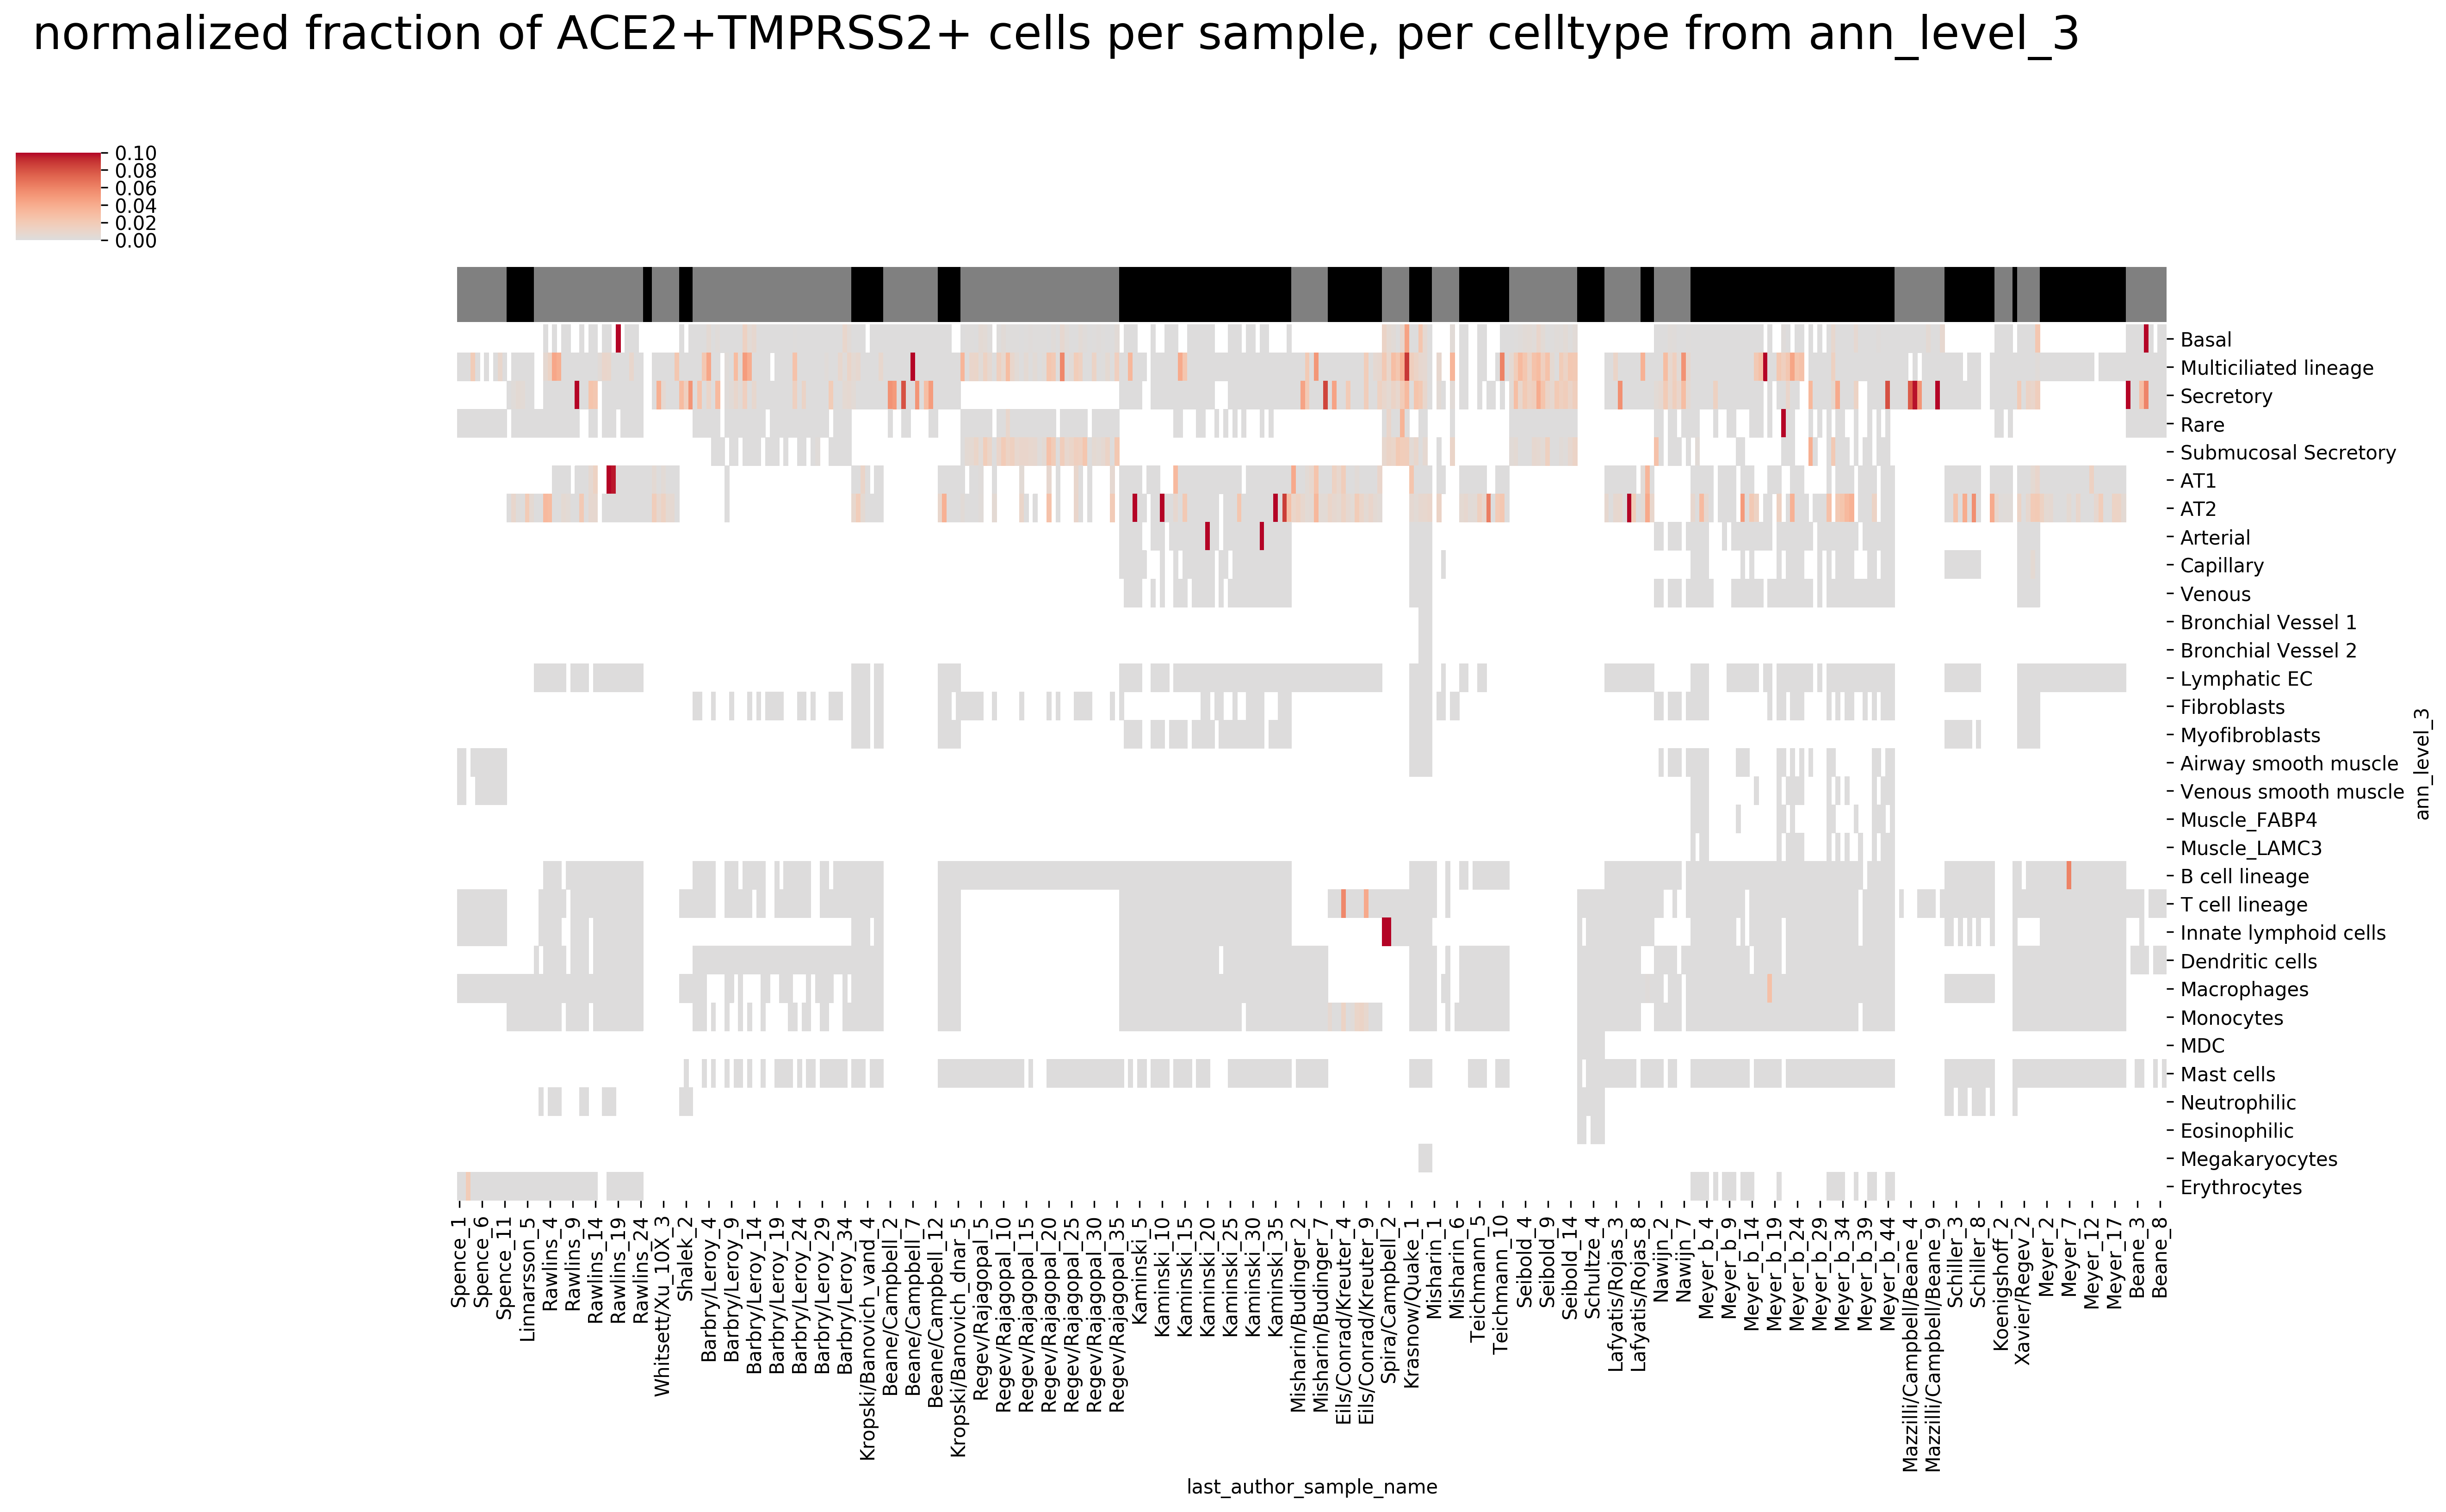

In [87]:
# note that we're setting the color saturation at lower than the maximum value,
# to be able to see color differences in celltypes/samples with lower dp fractions
color_max_cutoff = 0.1
# now plot heatmap
heat = sns.clustermap(
    sample_ct_norm_dp_fractions.T,
    center=0,
    vmax=color_max_cutoff,
    cmap="coolwarm",
    col_colors=x_bar_colors_dataset,
    row_cluster=False,
    col_cluster=False,
    figsize=(20, 10),
)
ax = heat.ax_heatmap
heat.fig.suptitle(
    "normalized fraction of ACE2+TMPRSS2+ cells per sample, per celltype from "
    + level_name,
    fontsize=24,
)
plt.tight_layout()
# save figure
plt.savefig(
    folder + "/supp15_bottom.pdf", dpi=300, bbox_inches="tight",
)
# show graphic
plt.show()
plt.close()